# Week 12: Uplift models (sklift)

https://alabhya.medium.com/causal-machine-learning-using-ml-models-in-social-experiments-4c00070390bd

## Introduction

In this lab, we'll take a look at uplift modeling. This is an extension to causal machine learning that focuses on trying to better understand the variations in the treatment effect among individuals. One particular goal is to try and identify both the individuals who have the greatest effect and those who have the lowest. This information can then be used to better targer treatment in marketing, medicine, etc. There are several Python libraries that are designed to help with this, including **pylift**, **causalML** and **scikit-lift**. We'll use the last of these here in conjunction with the **EconML** library for modeling.


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from econml.dml import LinearDML
from lightgbm import LGBMRegressor, LGBMClassifier


## Data

We'll use the data in the file *vocational.csv* for this lab. This is a synthetic dataset examining the effect of training (the `treatment`) on a student's success (the `outcome`), measured by whether or not they were able to obtain a job in the six months following the training. 

The goal is to first ensure that the training is useful generally. This can be measured by the average treatment effect (ATE). Second, as the training is expensive and resources are limited, we want to identify the students for whom the training is most effect so that we can prioritize these in the future. To assess this, an experiment was designed in which 15,000 students were randomly selected to receive the training, and a similar number as controls. 


The dataset contains the following fields. We assume that the other variables recorded can act as confounders in the model.

- `treatment`: if or not the student got treatment. It is assigned at random
- `age`: the age of the student training ranges from 18–22
- `score`: the score they obtain at school level examination (grade 10)
- `gender`: Male or Female
- `experience`: if they have previous experience or not
- `previous_exp`: how many months of previous experience
- `distance_majorcity`: how far they live from a major city
- `owns_motor`: if they have a motor vehicle
- `placement`: did they get the job after the end of their education

In [48]:
df = pd.read_csv("./data/vocational.csv")
df.columns

Index(['ind', 'treatment', 'age', 'score', 'gender', 'experience',
       'previous_exp', 'distance_majorcity', 'owns_motor', 'placement'],
      dtype='object')

Next, let's pre-process the data. We'll need to remove the ID field (`ind`) and one-hot encode the `gender` variable. 

In [49]:
dummies = pd.get_dummies(df['gender'], drop_first=True, dtype='int')
df = pd.concat([df, dummies], axis=1)
df.drop(['ind','gender'], axis=1, inplace=True)

In [50]:
df.head()

,treatment,age,score,experience,previous_exp,distance_majorcity,owns_motor,placement,M
0,0,18,75,0,0,3.567556,1,0,0
1,1,19,73,0,0,5.726959,1,0,1
2,1,20,77,1,16,8.398042,0,1,1
3,0,20,71,0,0,4.364674,1,0,0
4,1,22,78,0,0,5.342594,1,0,0


In [51]:
print('Total number of samples: {}'.format(len(df)))

Total number of samples: 30000


The data are roughly equally split between control (`treatment = 0`) and treated (`treatment = 1`), so the data are roughly balanced. 

In [52]:
df['treatment'].value_counts(normalize = True)

treatment
0    0.501067
1    0.498933
Name: proportion, dtype: float64

For the outcome (`placement`), the data are unbalanced, with more 0's (students that did not get the job). In practice, it would be worth trying to balance this a little better for the modeling section (we won't do that here). 

In [53]:
df['placement'].value_counts(normalize = True)

placement
0    0.75
1    0.25
Name: proportion, dtype: float64

## Average treatment effect

Before we do anything else, let's get a naive estimate of the average treatment effect. We'll do this by simply comparing the conversion rate between the control and treatment group. The conversion rate is simply the number of successful placements divided by the total number of students in that group.

In [54]:
# Conversion and conversion rate by treatment group
treatment_group = df[df['treatment'] == 1]
control_group = df[df['treatment'] == 0]

# Number of users and conversion rate in treatment group
treatment_converted = treatment_group['placement'].sum()
treatment_total = len(treatment_group)
treatment_conversion_rate = treatment_converted / treatment_total

# Number of users and conversion rate in control group
control_converted = control_group['placement'].sum()
control_total = len(control_group)
control_conversion_rate = control_converted / control_total

# Create a summary table
summary_table = pd.DataFrame({
    '': ['Total Users', 'Converted Users', 'Conversion Rate (%)'],
    'Treatment Group': [treatment_total, treatment_converted, f"{treatment_conversion_rate * 100:.2f}%"],
    'Control Group': [control_total, control_converted, f"{control_conversion_rate * 100:.2f}%"]
})
display(summary_table)

# Difference in conversion rate
conversion_rate_difference = treatment_conversion_rate - control_conversion_rate
print(f"Difference in Conversion Rate between Treatment and Control Groups: {conversion_rate_difference * 100:.2f}% "
      f"(Treatment: {treatment_conversion_rate * 100:.2f}%, Control: {control_conversion_rate * 100:.2f}%)")

,,Treatment Group,Control Group
0,Total Users,14968,15032
1,Converted Users,4840,2660
2,Conversion Rate (%),32.34%,17.70%


Difference in Conversion Rate between Treatment and Control Groups: 14.64% (Treatment: 32.34%, Control: 17.70%)


From this we get:

- Treatment Group: 32.3% conversion rate (percentage of students who were trained and received a placement)
- Control Group: 17.7% conversion rate (percentage of tudents who were not trained and received a placement)
- A difference (ATE) of roughly 14.6%

This assumes that the treatment is assigned randomly - we'll next look at removing any bias in this and compare the results. 

Finally, we'll split up the data into the usually set of arrays:

- `X`: the features
- `y`: the outcome
- `T`: the treatment

Note that we are using the entire dataset to train the model. in practice, we'd split into a training and testing set for this.

In [55]:
features = ['age', 'score', 'experience', 'previous_exp',
       'distance_majorcity', 'owns_motor', 'M']
X = df[features]
y = df['placement']
T = df['treatment']

## LinearDML

We'll use a double machine learning approach here. As a reminder: the argument `W` indicates that we want to use the features to debias the data (removing any confouding effect), and the argument `X` indicates that we want to use the features to estimate variations in the treatment effect by individual student. We'll start with the `linearDML` model, that estimates individual effects as a linear function of the features

In [ ]:
np.random.seed(123)

dml = LinearDML(model_y='auto', 
                model_t='auto', 
                discrete_treatment=True)
dml.fit(y, T=T, X=X, W=X)

Estimated ATE: 14.00%


Once fit, we can extract the ATE from this model, as well as the set of individual effects with `effect`:

In [67]:
# Calculate average treatment effect
ate_dml = round(dml.ate(X=X), 2)
print(f"Estimated ATE: {ate_dml * 100:.2f}%")

# Get the individual treatment effect
treatment_effect = dml.effect(X=X.values)

Estimated ATE: 14.00%


Note here that the ATE is very slightly lower than in the naive estimate suggesting that there is some degree of non-randomness in the treatment assignments. The difference is pretty minimal here (due to the way that the data were produced). To illustrate this, we'll plot out the effects. For the control group, we simply need the control conversion rate (`control_conversion_rate`). For the treatment group, we'll decompose this into:

- The base conversion (i.e. the same as the control conversion)
- The treatment conversion (the true ATE)
- The selection bias as the total treatment effect minus the ATE + the base conversion

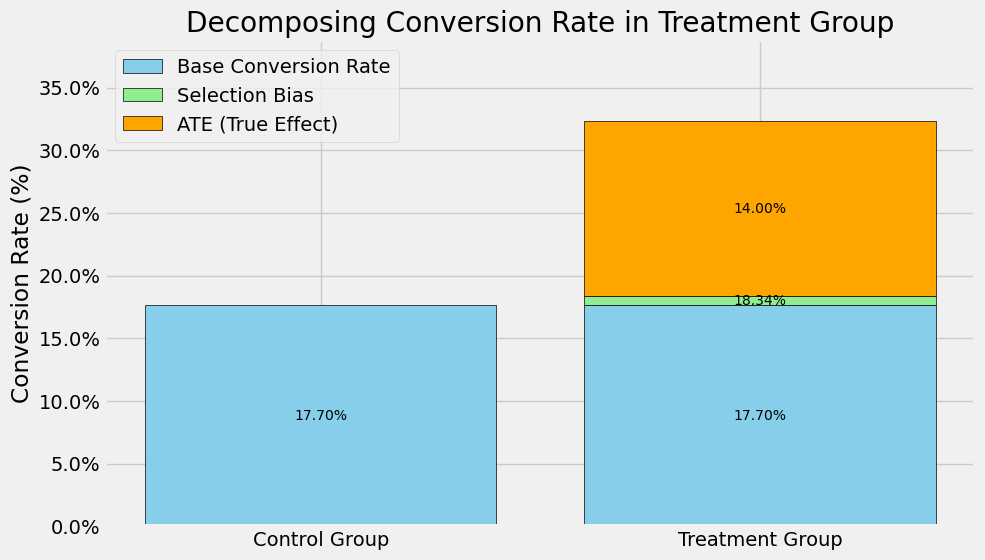

In [68]:
selection_bias = treatment_conversion_rate - ate_dml

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars for Treatment Group
base_conversion = control_conversion_rate
selection_bias_height = selection_bias - control_conversion_rate
ate_height = ate_dml

# Create the bar plot
ax.bar('Control Group', control_conversion_rate, color='skyblue', edgecolor='black', label='Base Conversion Rate')
ax.bar('Treatment Group', base_conversion, color='skyblue', edgecolor='black')  # No label to avoid duplication
ax.bar('Treatment Group', selection_bias_height, bottom=base_conversion, color='lightgreen', edgecolor='black', label='Selection Bias')
ax.bar('Treatment Group', ate_height, bottom=base_conversion + selection_bias_height, color='orange', edgecolor='black', label='ATE (True Effect)')

# Adding text labels for each segment
ax.text(0, control_conversion_rate / 2, f'{control_conversion_rate * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion / 2, f'{base_conversion * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion + selection_bias_height / 2, f'{selection_bias * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion + selection_bias_height + ate_height / 2, f'{ate_dml * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)

# Customizing plot
ax.set_ylim(0, treatment_conversion_rate * 1.2)
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('Decomposing Conversion Rate in Treatment Group')

# Adding legend
ax.legend()

# Format y-axis to show percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y * 100)))

plt.show()

### Modeled uplift

Now we'll examine the uplift from this model. The uplift is simply the individual treatment effect that we obtained earlier, but there are a couple of standard ways to visualize and examine this.

In [58]:
from econml.cate_interpreter import SingleTreeCateInterpreter
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(dml, X)

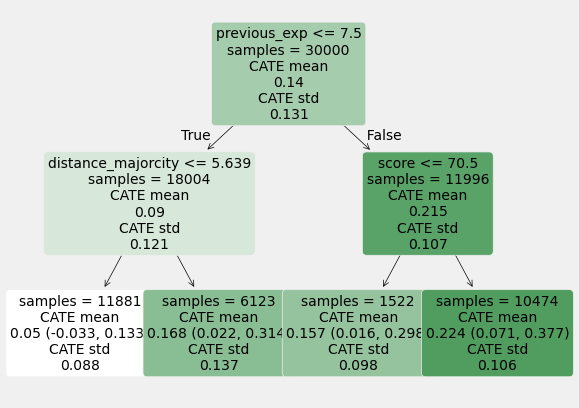

In [88]:
# Plot the tree
intrp.plot(feature_names=features, fontsize=10)

In [ ]:
# mod_t = dml.models_t[0][0]
# mod_t.feature_importances_[0:7]

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [61]:
uplift_results = pd.DataFrame({'DML': dml.effect(X)})

best_treatment = np.where(uplift_results['DML'] < 0, 'control', 'treatment')

best_treatment

array(['treatment', 'treatment', 'treatment', ..., 'treatment',
       'treatment', 'treatment'], dtype='<U9')

In [62]:
uplift_results

,DML
0,0.089320
1,0.109003
2,0.300098
3,0.028719
4,0.058529
...,...
29995,0.249925
29996,0.024095
29997,0.110364
29998,0.176568


In [63]:
uplift_results = uplift_results.assign(is_treated=T, placement=y)

In [64]:
from causalml.metrics import plot_gain, plot_qini

In [65]:
uplift_results

,DML,is_treated,placement
0,0.089320,0,0
1,0.109003,1,0
2,0.300098,1,1
3,0.028719,0,0
4,0.058529,1,0
...,...,...,...
29995,0.249925,1,1
29996,0.024095,1,0
29997,0.110364,1,0
29998,0.176568,0,0


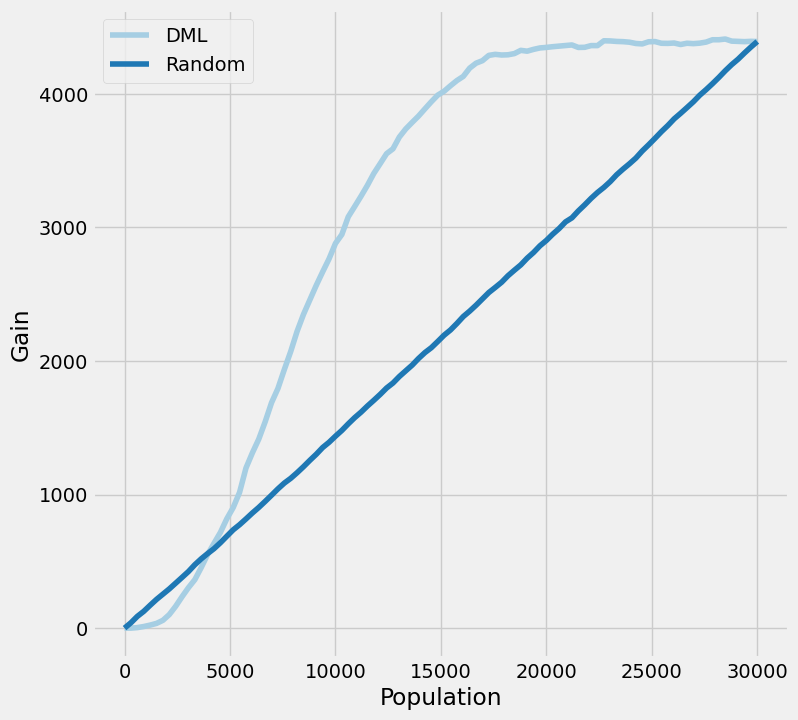

In [66]:
# plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')
plot_gain(uplift_results, outcome_col='placement', treatment_col='is_treated')

In [24]:
from causalml.metrics import auuc_score
score = auuc_score(uplift_results, outcome_col='placement', treatment_col='is_treated')
print(score)

DML       0.708261
Random    0.495550
dtype: float64


## Causal Forest DML

In [ ]:
np.random.seed(123)

from econml.dml import CausalForestDML

cfdml = CausalForestDML(model_t='auto',
                        model_y='auto',
                        discrete_treatment=True)


cfdml.fit(y, T, X=X, W=X)

Estimated ATE: 14.00%


In [ ]:
# Calculate average treatment effect
ate_cfdml = round(cfdml.ate(X=X), 2)

treatment_effect = cfdml.effect(X=X.values)

# Output the estimated ATE as a percentage
print(f"Estimated ATE: {ate_cfdml * 100:.2f}%")

In [26]:
# uplift_results = pd.DataFrame({'effect': cfdml.effect(X)})
uplift_results = uplift_results.assign(CFDML=cfdml.effect(X))

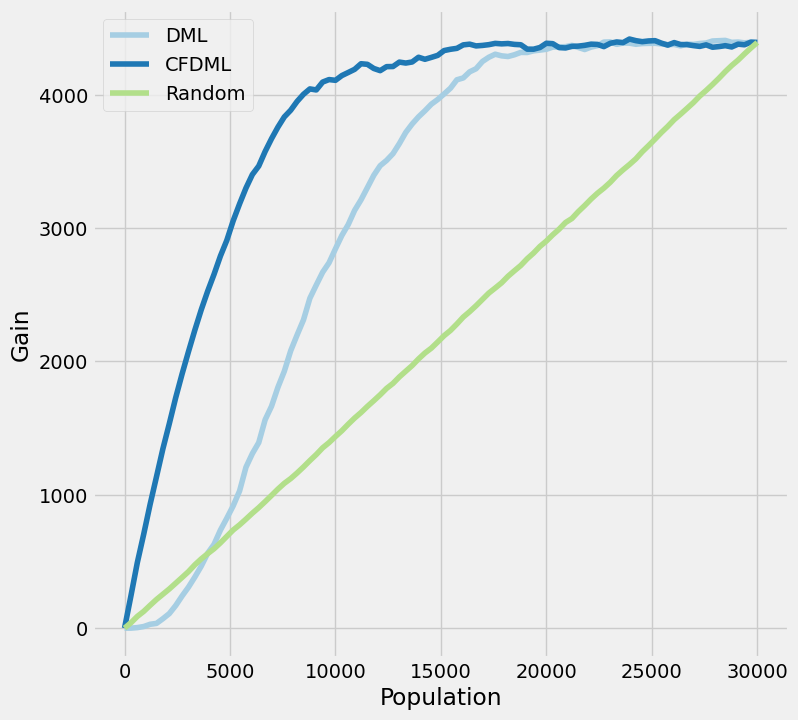

In [27]:
plot_gain(uplift_results, outcome_col='placement', treatment_col='is_treated')

In [28]:
score = auuc_score(uplift_results, outcome_col='placement', treatment_col='is_treated')
print(score)

DML       0.708261
CFDML     0.862767
Random    0.495550
dtype: float64


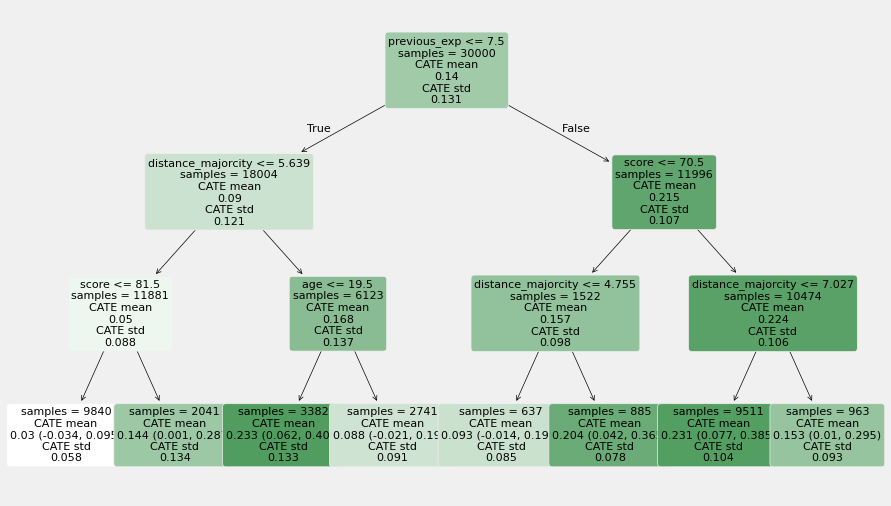

In [91]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrp.interpret(cfdml, X)

# Plot the tree
# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))
intrp.plot(feature_names=features, fontsize=8)

## Decile plot

In [29]:
# Create deciles
uplift_results['decile'] = 10-pd.qcut(uplift_results['CFDML'], 10, labels=False)
uplift_results

,DML,is_treated,placement,CFDML,decile
0,0.089839,0,0,0.006599,8
1,0.107993,1,0,0.030386,7
2,0.300009,1,1,0.189174,4
3,0.030089,0,0,0.000114,10
4,0.059806,1,0,0.012492,8
...,...,...,...,...,...
29995,0.252116,1,1,0.257083,3
29996,0.025769,1,0,-0.002842,10
29997,0.110103,1,0,0.099214,6
29998,0.175004,0,0,0.287756,2


In [30]:
uplift_df = uplift_results.groupby('decile').agg(
    treatment_count=pd.NamedAgg(column="is_treated", aggfunc="sum"),
    treatment_placement=('is_treated', lambda x: (x * uplift_results.loc[x.index, 'placement']).sum()),
    control_count=('is_treated', lambda x: (-(x-1)).sum()),
    control_placement=('is_treated', lambda x: (-(x-1) * uplift_results.loc[x.index, 'placement']).sum())
)

In [31]:
uplift_df['decile'] = uplift_df.index.values

In [32]:
uplift_df['uplift'] = (uplift_df['treatment_placement'] / uplift_df['treatment_count'] - uplift_df['control_placement'] / uplift_df['control_count']) * 100

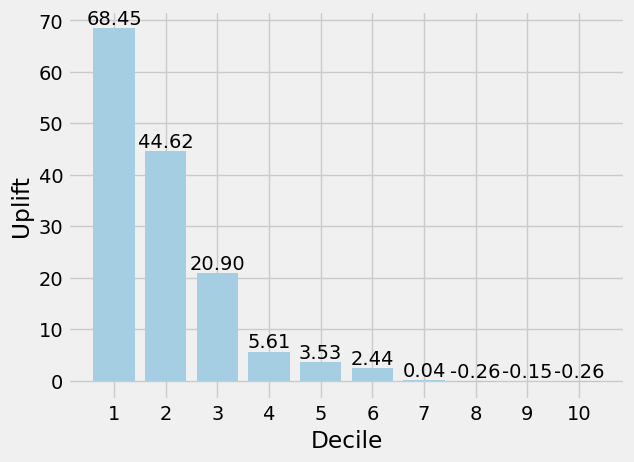

In [33]:
plt.bar(uplift_df['decile'].astype(str), uplift_df['uplift'])
plt.xlabel('Decile')
plt.ylabel('Uplift')

deciles = uplift_df['decile'].to_list()
uplift_values = uplift_df['uplift'].to_list()
for i, value in enumerate(uplift_values):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')
plt.show()

In [34]:
uplift_df['treatment_count_cumulative'] = uplift_df['treatment_count'].cumsum()
uplift_df['treatment_placement_cumulative'] = uplift_df['treatment_placement'].cumsum()
uplift_df['control_count_cumulative'] = uplift_df['control_count'].cumsum()
uplift_df['control_placement_cumulative'] = uplift_df['control_placement'].cumsum()

uplift_df

,treatment_count,treatment_placement,control_count,control_placement,decile,uplift,treatment_count_cumulative,treatment_placement_cumulative,control_count_cumulative,control_placement_cumulative
decile,,,,,,,,,,
1,1518,1250,1482,206,1,68.445056,1518,1250,1482,206
2,1509,1071,1491,393,2,44.616006,3027,2321,2973,599
3,1469,783,1531,496,3,20.904440,4496,3104,4504,1095
4,1525,647,1475,543,4,5.612670,6021,3751,5979,1638
5,1477,504,1523,466,5,3.525718,7498,4255,7502,2104
6,1501,344,1499,307,6,2.437734,8999,4599,9001,2411
7,1522,188,1478,182,7,0.038230,10521,4787,10479,2593
8,1443,50,1557,58,8,-0.260109,11964,4837,12036,2651
9,1539,3,1461,5,9,-0.147300,13503,4840,13497,2656


In [81]:
uplift_df['uplift_cumulative'] = uplift_df['treatment_placement_cumulative'] - (uplift_df['control_placement_cumulative'] / uplift_df['control_count_cumulative']) * uplift_df['treatment_count_cumulative']

# uplift_df['uplift_cumulative_percent'] = uplift_df['uplift_cumulative'] / uplift_df['treatment_count_cumulative'].sum() * 100
uplift_df['uplift_cumulative_percent'] = uplift_df['uplift_cumulative'] / uplift_df['uplift_cumulative'].iloc[-1] * 100

In [82]:
uplift_df

,treatment_count,treatment_placement,control_count,control_placement,decile,uplift,treatment_count_cumulative,treatment_placement_cumulative,control_count_cumulative,control_placement_cumulative,uplift_cumulative,uplift_cumulative_percent
decile,,,,,,,,,,,,
1,1518,1250,1482,206,1,68.445056,1518,1250,1482,206,1038.995951,47.414047
2,1509,1071,1491,393,2,44.616006,3027,2321,2973,599,1711.120081,78.086087
3,1469,783,1531,496,3,20.904440,4496,3104,4504,1095,2010.944938,91.768441
4,1525,647,1475,543,4,5.612670,6021,3751,5979,1638,2101.493728,95.900588
5,1477,504,1523,466,5,3.525718,7498,4255,7502,2104,2152.121834,98.210976
6,1501,344,1499,307,6,2.437734,8999,4599,9001,2411,2188.535718,99.872705
7,1522,188,1478,182,7,0.038230,10521,4787,10479,2593,2183.607214,99.647795
8,1443,50,1557,58,8,-0.260109,11964,4837,12036,2651,2201.858425,100.480680
9,1539,3,1461,5,9,-0.147300,13503,4840,13497,2656,2182.819293,99.611839


In [83]:
uplift_df['decile'] = uplift_df.index.values

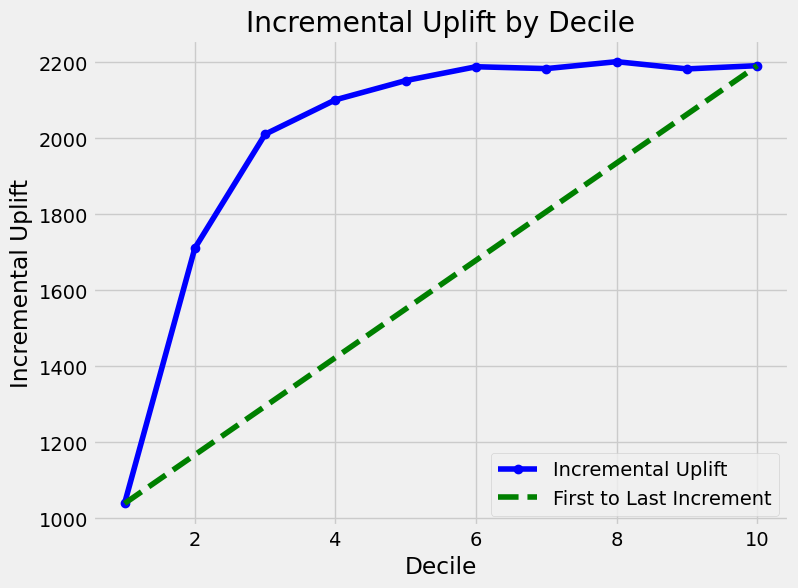

In [85]:
plt.figure(figsize=(8, 6))
decile = uplift_df['decile'].to_list()
increment_uplift = uplift_df['uplift_cumulative_percent'].to_list()

# Plot line and points for incremental uplift
plt.plot(uplift_df['decile'], uplift_df['uplift_cumulative'], color='blue', label='Incremental Uplift', marker='o')

# Add dashed line between the first and last incremental uplift values
plt.plot([decile[0], decile[-1]], [uplift_df['uplift_cumulative'].iloc[0], uplift_df['uplift_cumulative'].iloc[-1]], 
         linestyle='dashed', color='green', label="First to Last Increment")

# Add labels and title
plt.title("Incremental Uplift by Decile")
plt.xlabel("Decile")
plt.ylabel("Incremental Uplift")

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

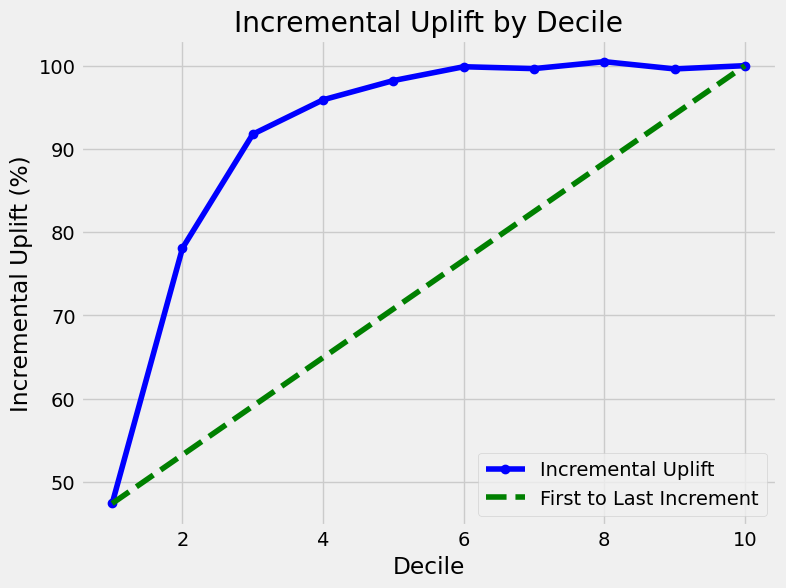

In [87]:
plt.figure(figsize=(8, 6))
decile = uplift_df['decile'].to_list()
increment_uplift = uplift_df['uplift_cumulative_percent'].to_list()

# Plot line and points for incremental uplift
plt.plot(uplift_df['decile'], uplift_df['uplift_cumulative_percent'], color='blue', label='Incremental Uplift', marker='o')

# Add dashed line between the first and last incremental uplift values
plt.plot([decile[0], decile[-1]], [increment_uplift[0], increment_uplift[-1]], 
         linestyle='dashed', color='green', label="First to Last Increment")

# Add labels and title
plt.title("Incremental Uplift by Decile")
plt.xlabel("Decile")
plt.ylabel("Incremental Uplift (%)")

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## Interpretation

In [38]:
from econml.cate_interpreter import SingleTreeCateInterpreter
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
# We interpret the CATE model's behavior based on the features used for heterogeneity
intrp.interpret(cfdml, X)

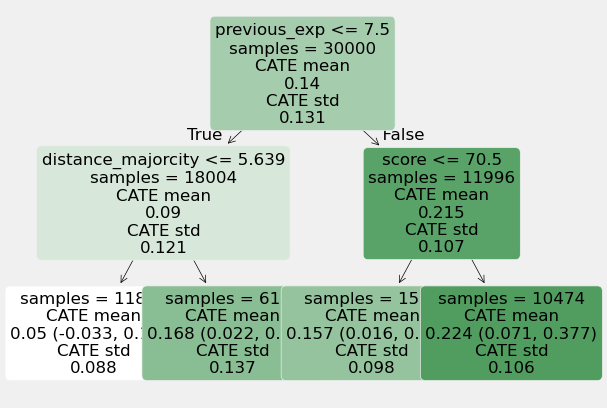

In [39]:
# Plot the tree
intrp.plot(feature_names=features, fontsize=12)

In [40]:
cfdml.feature_importances_

array([2.99810904e-02, 5.98478320e-02, 2.48923746e-02, 7.59929691e-01,
       1.22253452e-01, 2.69431048e-03, 4.01249126e-04])

<Axes: xlabel='importance', ylabel='feature'>

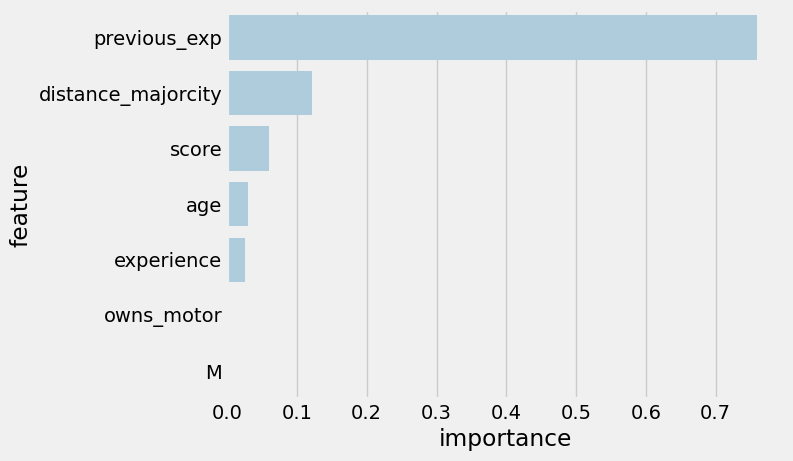

In [41]:
importances = cfdml.feature_importances_
indices = np.argsort(importances)[::-1]
df = pd.DataFrame({'feature': X.columns[indices],
                   'importance': importances[indices]})
#sns.set()
#sns.barplot(y = X.columns, x = importances)
sns.barplot(df, x = 'importance', y = 'feature')

In [117]:
dir(cfdml.model_final)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 '_validate_params',
 'estimator',
 'feature_importances',
 'feature_importances_',
 'fit',
 'get_metadata_routing',
 'get_params',
 'oob_predict',
 'predict',
 'predict_and_var

In [42]:
import shap
shap_values = cfdml.shap_values(X)

100%|===================| 29953/30000 [07:12<00:00]        

In [105]:
shap_values['placement']['treatment_1']

.values =
array([[ 7.26117023e-03,  7.51319066e-02, -2.75983686e-05, ...,
        -2.32225161e-01, -4.42948252e-02, -2.97562015e-02],
       [-1.31454397e-02, -1.82217787e-01, -9.52992224e-03, ...,
         2.29913281e-01, -5.91131381e-02,  4.68065959e-03],
       [ 2.26098235e-01,  5.49532912e-02, -2.48356265e-01, ...,
         4.53111328e-01, -1.63548406e-02,  5.55439743e-02],
       ...,
       [-2.33146793e-01, -1.39009843e-01,  8.56904855e-04, ...,
        -3.04194613e-01,  6.58581695e-02, -1.90332372e-01],
       [ 2.50161095e-02, -2.66398764e-01,  1.36873077e-03, ...,
         1.79379694e-01,  2.95772424e-01,  1.45229962e-02],
       [ 1.11887500e-02,  9.38885615e-03, -2.82667774e-02, ...,
        -6.01138520e-03, -6.03517750e-02, -2.00709855e-03]])

.base_values =
array([0.05922911, 0.05922911, 0.05922911, ..., 0.05922911, 0.05922911,
       0.05922911])

.data =
array([[18.        , 75.        ,  0.        , ...,  3.56755605,
         1.        ,  0.        ],
       [19.     

In [106]:
np.argmin(shap_values['placement']['treatment_1'].base_values)

0

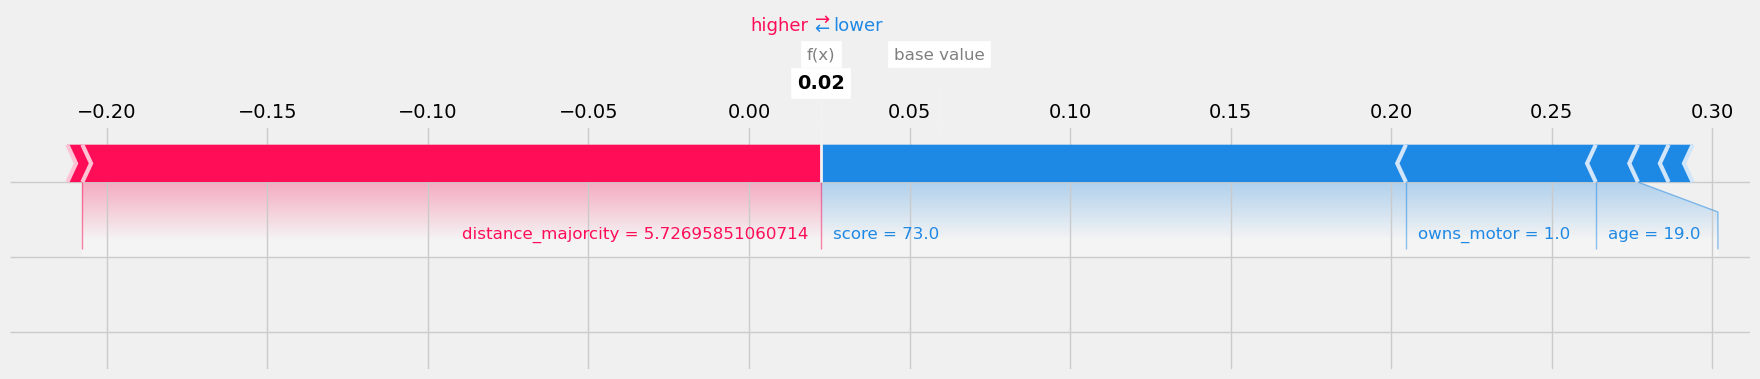

In [44]:
# local view: explain heterogeneity for a given observation
ind=1
shap.plots.force(shap_values['placement']['treatment_1'][ind], matplotlib=True)

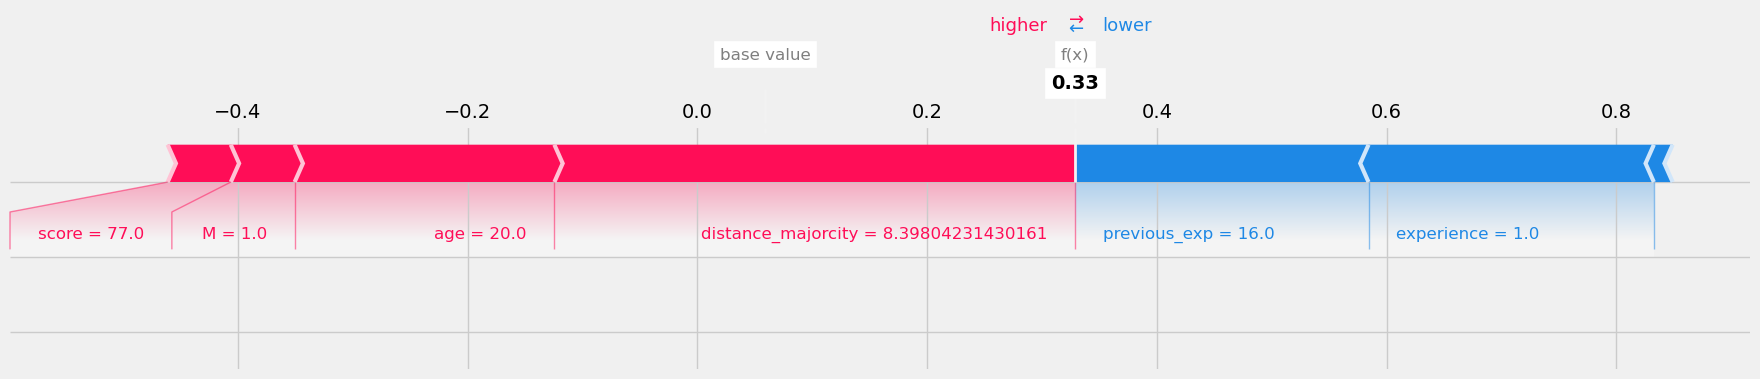

In [140]:
# local view: explain heterogeneity for a given observation
ind=2
shap.plots.force(shap_values['placement']['treatment_1'][ind], matplotlib=True)

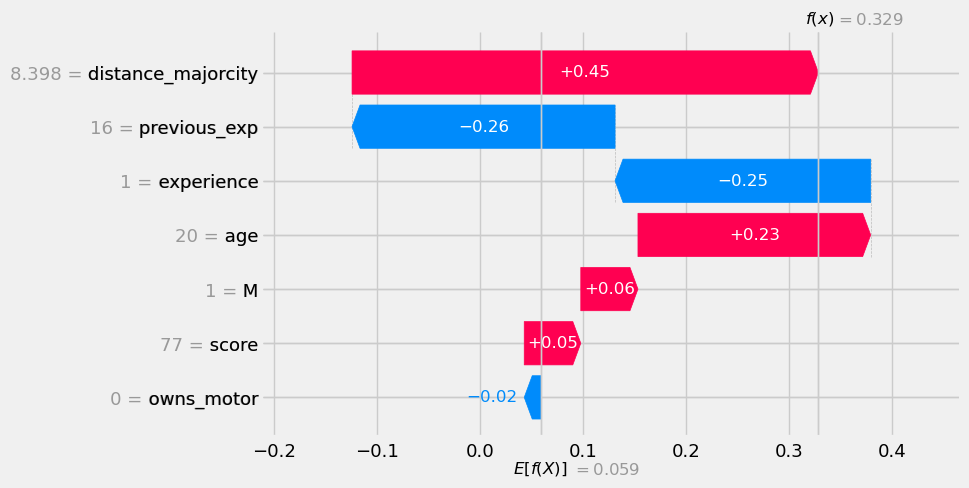

In [141]:
shap.plots.waterfall(shap_values['placement']['treatment_1'][ind])

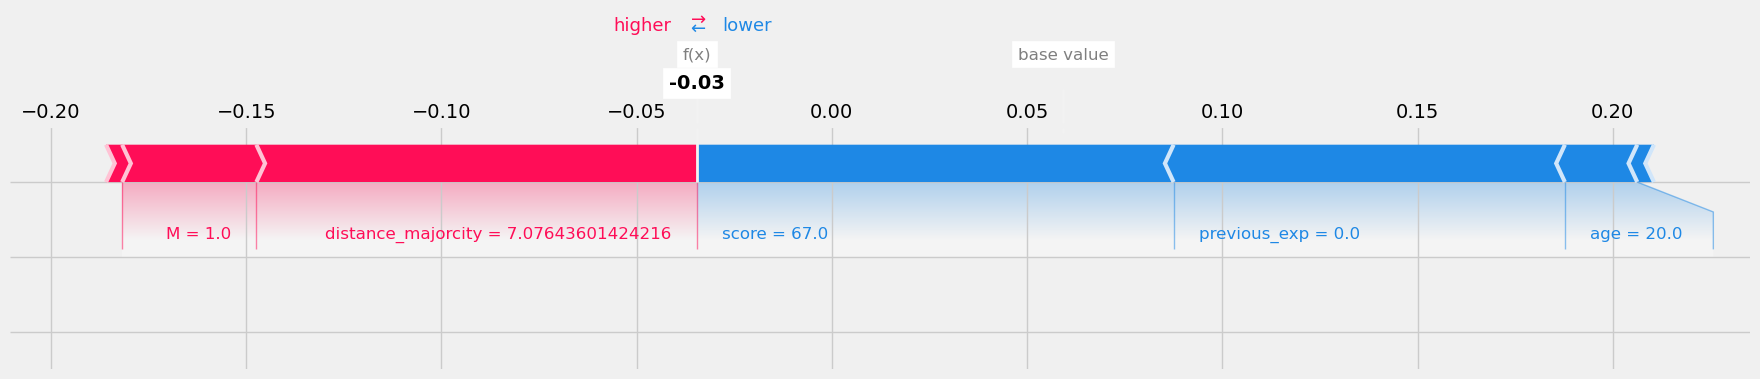

In [142]:
# local view: explain heterogeneity for a given observation
ind=400
shap.plots.force(shap_values['placement']['treatment_1'][ind], matplotlib=True)

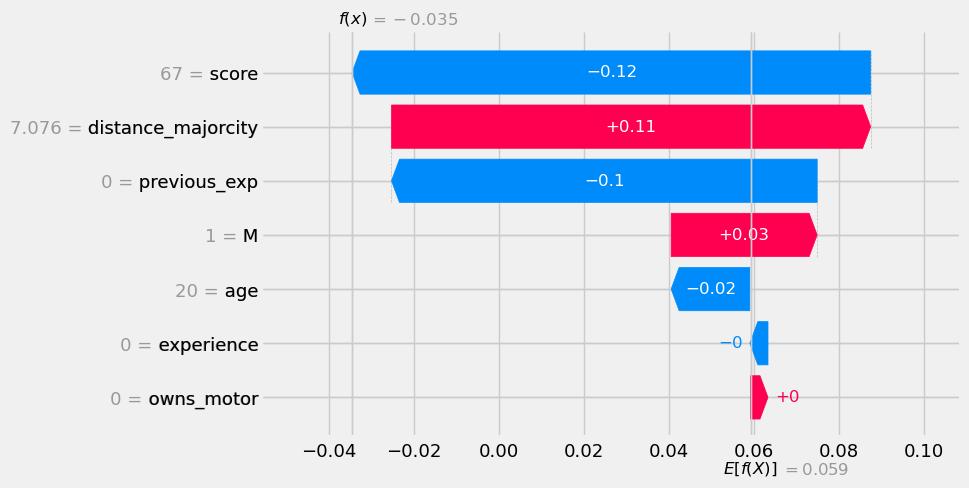

In [143]:
shap.plots.waterfall(shap_values['placement']['treatment_1'][ind])

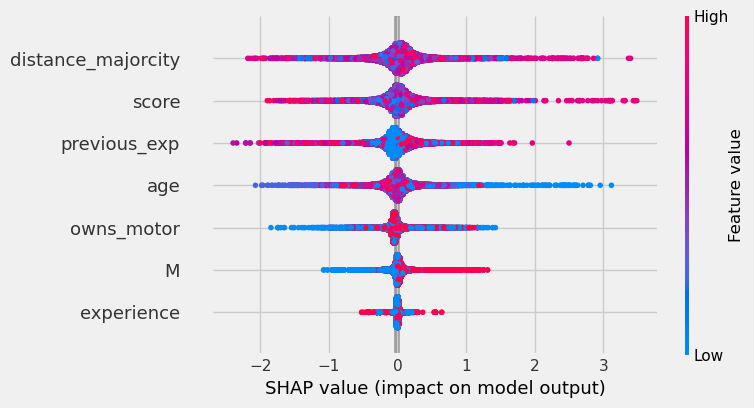

In [45]:
# global view: explain heterogeneity for a sample of dataset
shap.summary_plot(shap_values['placement']['treatment_1'])

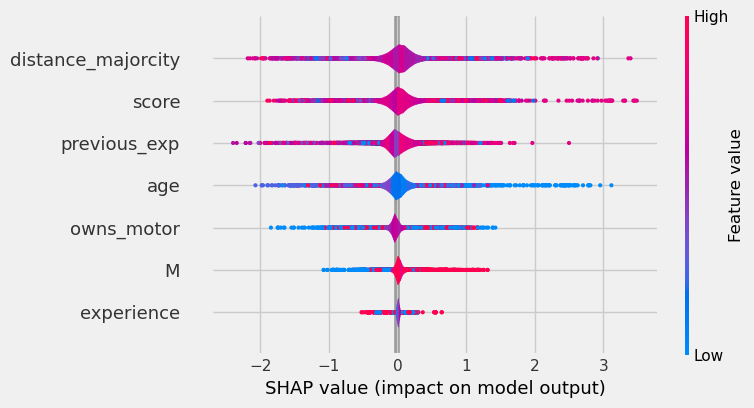

In [137]:
# global view: explain heterogeneity for a sample of dataset
shap.summary_plot(shap_values['placement']['treatment_1'], plot_type='violin')